In [71]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.basemap import Basemap
import matplotlib
import matplotlib.pyplot as plt
import StamenTonerTilesAccess as STT
import requests
import StringIO
from PIL import Image
from scipy import stats
import json

# from sklearn.neighbors import KernelDensity
# from sklearn.grid_search import GridSearchCV

In [14]:
# DON'T RUN THIS CELL UNLESS THE CRIME_DATA FILE IS LOST

# This is the URL for the Philly PD crime incidents 2006-present API, and the requested data is given as a csv
url = 'https://data.phila.gov/resource/sspu-uyfa.csv?'

# This is my identifier 
token = '$$app_token=r3XjAbgHWtqqrmZCcdIpEd97O'

# By default, a request only gets me 1000 points, but there are over 2 million. I set limit to 3 million
limit = '&$limit=3000000'

# The API allows me to select columns a priori
cols= '&$select='

# These are the columns I want
col1 = 'dispatch_date AS Date'
col2 = ',dispatch_time AS Time'
col3 = ',ucr_general AS CrimeCodeNo'
col4 = ',text_general_code AS CrimeCodeText'
col5 = ',point_x AS lon'
col6 = ',point_y AS lat'

try:
    # Append the url and request the data
    response = requests.get(url+token+limit+cols+col1+col2+col3+col4+col5+col6)
    
    # Make the response readable
    csvdata = StringIO.StringIO(response.content)
    
    # Store it in a dataframe
    df = pd.read_csv(csvdata)
    
    # Pickle the dataframe so we don't have to keep requesting each time we want to use the data,
    # we can just load using pd.read_pickle('crime_data')
    df.to_pickle('crime_data')

except requests.exceptions.RequestException as e:
    print e
    sys.exit(1)


In [70]:
# Read data from pickle if we are starting a new session
df = pd.read_pickle('crime_data')

In [3]:
df.head()

CrimeCodeNo       CrimeCodeText        Date      Time        lat        lon
0          800      Other Assaults  2009-10-02  14:24:00        NaN        NaN
1         2600  All Other Offenses  2009-05-10  00:55:00        NaN        NaN
2          800      Other Assaults  2009-08-07  15:40:00        NaN        NaN
3         1500   Weapon Violations  2009-07-19  01:09:00  40.036389 -75.130477
4         2600  All Other Offenses  2009-06-25  00:14:00  39.969532 -75.166350

In [4]:
# We appear to be a data point in this set as well!
# This was when my (then) fiancee and I got robbed in 2010

mycrime = df[(df.Date=='2010-03-06') & (df.CrimeCodeText=='Robbery Firearm') & (df.Time=='22:02:00')]
mycrime

CrimeCodeNo    CrimeCodeText        Date      Time        lat  \
132994          300  Robbery Firearm  2010-03-06  22:02:00  39.935304   

             lon  
132994 -75.21782

In [5]:
# First let's drop the data points which have no latitude or longitude

df = df.dropna()
df.head()

CrimeCodeNo       CrimeCodeText        Date      Time        lat  \
3          1500   Weapon Violations  2009-07-19  01:09:00  40.036389   
4          2600  All Other Offenses  2009-06-25  00:14:00  39.969532   
5           600              Thefts  2015-04-25  12:50:00  39.940070   
6           800      Other Assaults  2009-02-10  14:33:00  39.979586   
12          600              Thefts  2015-10-06  18:18:00  39.976134   

          lon  
3  -75.130477  
4  -75.166350  
5  -75.166412  
6  -75.171149  
12 -75.160229

In [6]:
# Next, let's identify the crime code numbers corresponding to the different offenses

df.groupby(['CrimeCodeNo','CrimeCodeText']).count()

Date    Time     lat  \
CrimeCodeNo CrimeCodeText                                                     
100         Homicide - Criminal                        3188    3188    3188   
            Homicide - Gross Negligence                  11      11      11   
            Homicide - Justifiable                       41      41      41   
200         Rape                                      10860   10860   10860   
300         Robbery Firearm                           37898   37898   37898   
            Robbery No Firearm                        48507   48507   48507   
400         Aggravated Assault Firearm                25895   25895   25895   
            Aggravated Assault No Firearm             64270   64270   64270   
500         Burglary Non-Residential                  22100   22100   22100   
            Burglary Residential                      89670   89670   89670   
600         Theft from Vehicle                       158636  158636  158636   
            Thefts                                   236874  236874  236874   
700         Motor Vehicle Theft                       44462   44462   44462   
            Recovered Stolen Motor Vehicle            88130   88130   88130   
800         Other Assaults                           257464  257464  257464   
900         Arson                                      5309    5309    5309   
1000        Forgery and Counterfeiting                 4651    4651    4651   
1100        Fraud                                    104527  104527  104527   
1200        Embezzlement                               4334    4334    4334   
1300        Receiving Stolen Property                   738     738     738   
1400        Vandalism/Criminal Mischief              187252  187252  187252   
1500        Weapon Violations                         17460   17460   17460   
1600        Prostitution and Commercialized Vice      12094   12094   12094   
1700        Other Sex Offenses (Not Commercialized)   14520   14520   14520   
1800        Narcotic / Drug Law Violations           130502  130502  130502   
1900        Gambling Violations                         883     883     883   
2000        Offenses Against Family and Children       1694    1694    1694   
2100        DRIVING UNDER THE INFLUENCE               50088   50088   50088   
2200        Liquor Law Violations                      5340    5340    5340   
2300        Public Drunkenness                         4420    4420    4420   
2400        Disorderly Conduct                        38997   38997   38997   
2500        Vagrancy/Loitering                         6734    6734    6734   
2600        All Other Offenses                       412901  412901  412901   

                                                        lon  
CrimeCodeNo CrimeCodeText                                    
100         Homicide - Criminal                        3188  
            Homicide - Gross Negligence                  11  
            Homicide - Justifiable                       41  
200         Rape                                      10860  
300         Robbery Firearm                           37898  
            Robbery No Firearm                        48507  
400         Aggravated Assault Firearm                25895  
            Aggravated Assault No Firearm             64270  
500         Burglary Non-Residential                  22100  
            Burglary Residential                      89670  
600         Theft from Vehicle                       158636  
            Thefts                                   236874  
700         Motor Vehicle Theft                       44462  
            Recovered Stolen Motor Vehicle            88130  
800         Other Assaults                           257464  
900         Arson                                      5309  
1000        Forgery and Counterfeiting                 4651  
1100        Fraud                                    104527  
1200        Embezzlement                         

In [16]:
# We see that there are actually a large number of thefts. For now, let us focus on aggravated crimes like
# homicide, robbery, rape, assualt, burglary. These have crime codes 100-500 and 800
# Later, we can study motor vehicle thefts as well

# For now, we're also not going to care about time so we won't deal with this now. Later on, we can see how 
# crime changes based on times of the day

crime_df = df[(df.CrimeCodeNo<500) | (df.CrimeCodeNo==800)].drop('Time',axis=1)

# We can reset the index. This way, we won't run into problems later on when getting the year

crime_df = crime_df.reset_index().drop('index',axis=1)
crime_df.head()

CrimeCodeNo       CrimeCodeText        Date        lat        lon
0          800      Other Assaults  2009-02-10  39.979586 -75.171149
1          800      Other Assaults  2015-08-23  39.995626 -75.125869
2          300  Robbery No Firearm  2015-11-13  40.020219 -75.077126
3          800      Other Assaults  2015-10-29  39.968878 -75.236743
4          300     Robbery Firearm  2015-11-05  39.986415 -75.169577

In [8]:
# For now, we are only interested in the year the crime took place
crime_df['Year'] = pd.Series([int(date[0:4]) for date in crime_df.Date])
crime_loc_df = crime_df[['lat','lon','Year']]
crime_loc_df.head()

lat        lon  Year
0  39.979586 -75.171149  2009
1  39.995626 -75.125869  2015
2  40.020219 -75.077126  2015
3  39.968878 -75.236743  2015
4  39.986415 -75.169577  2015

In [9]:
%%capture

# From the data, we get the boundaries so that we can plot on a map
### This portion was done by Heather Simpson ###

# Find Max and Min Latitude and Longitude value where crimes take place

latmax = crime_df['lat'].max()
latmin = crime_df['lat'].min()
lonmax = crime_df['lon'].max()
lonmin = crime_df['lon'].min()

# Get the correct regions of the map from StamenToner

delta_lat = latmax-latmin
delta_long = lonmax-lonmin
zoom = 14

a, bbox = STT.getImageCluster(latmin, lonmin, delta_lat*.8,  delta_long*.8, zoom)
xmin = bbox[0]
ymin = bbox[1]
xmax = bbox[2]
ymax = bbox[3]

# Save the map as a figure

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
plt.axis("off")
m = Basemap(
    llcrnrlon=xmin, llcrnrlat=ymin,
    urcrnrlon=xmax, urcrnrlat=ymax,
    projection='merc', ax=ax
)
m.imshow(a, alpha=1, interpolation='lanczos', origin='upper')
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())  #gets extent of bbox for just the plot (without the frame/padding), so we can save just the plot extent (no frame / axis), allowing us to overlay the images later    
plotname = 'philly_map.png'
plt.savefig(plotname, bbox_inches=extent) #save image of plot
plt.close()

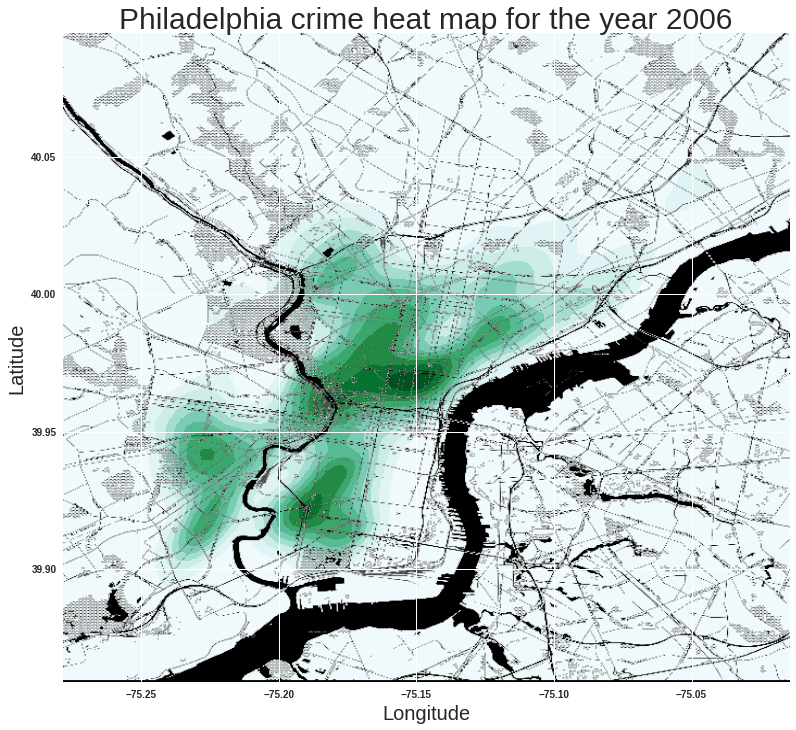

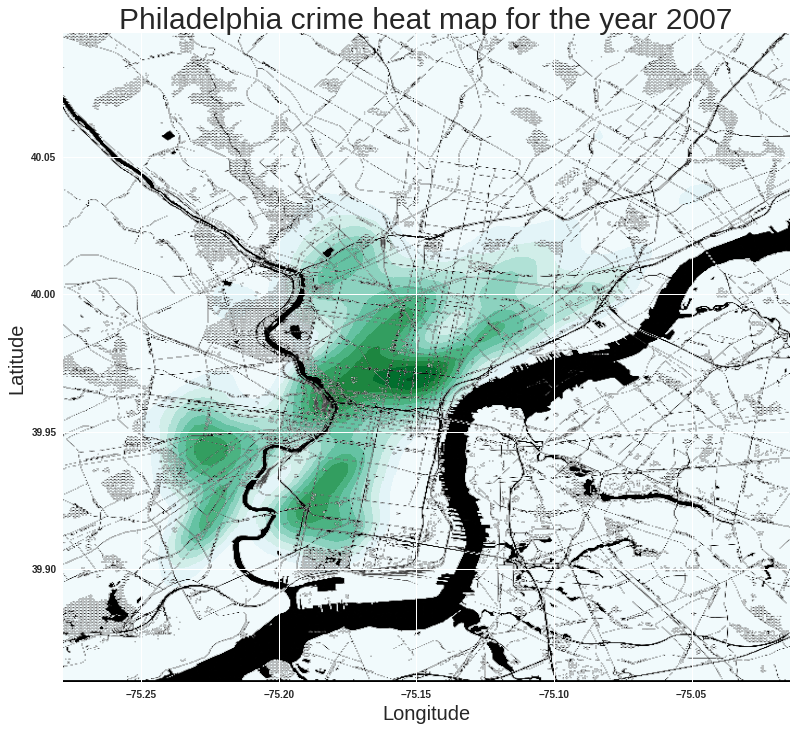

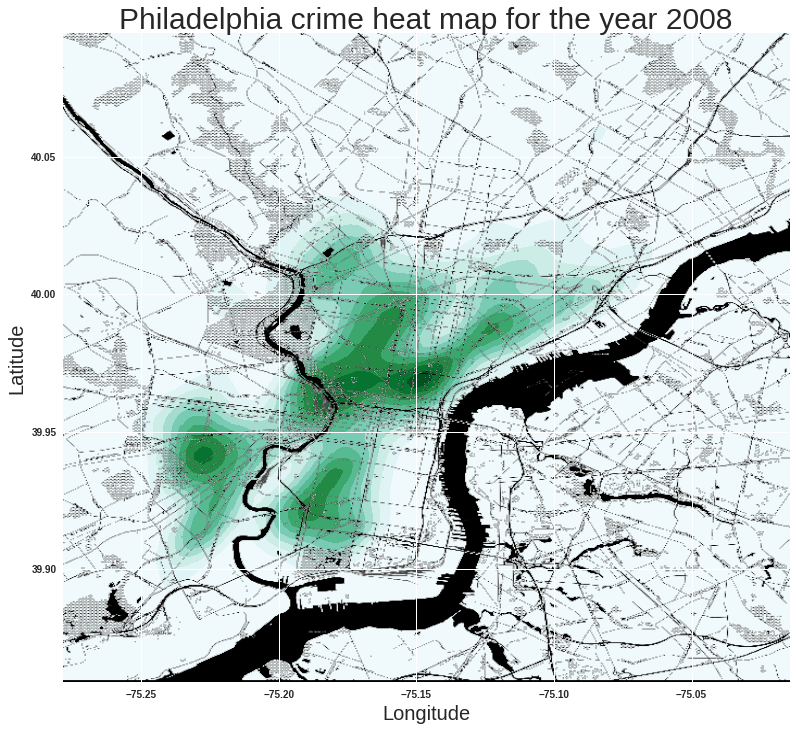

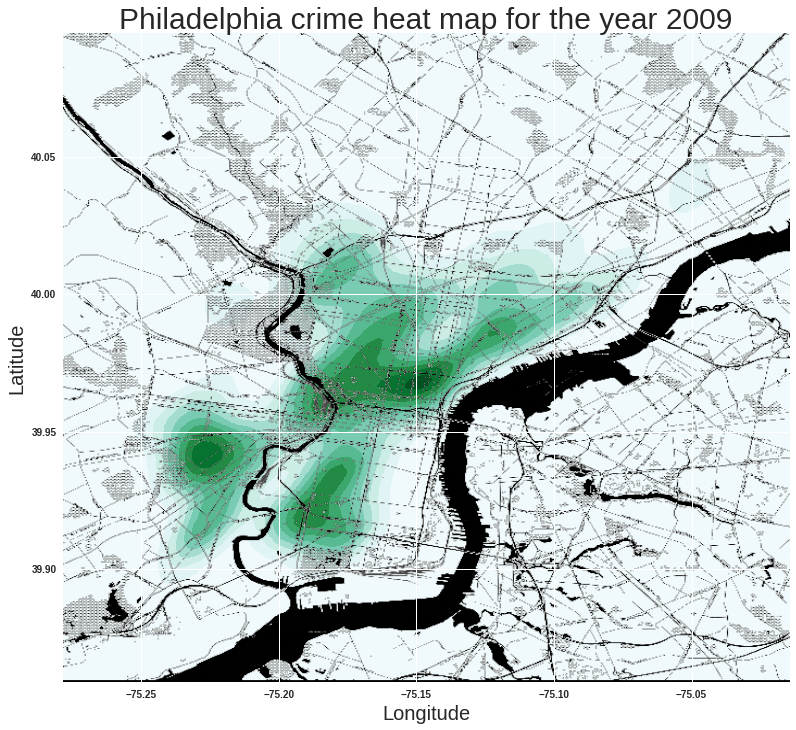

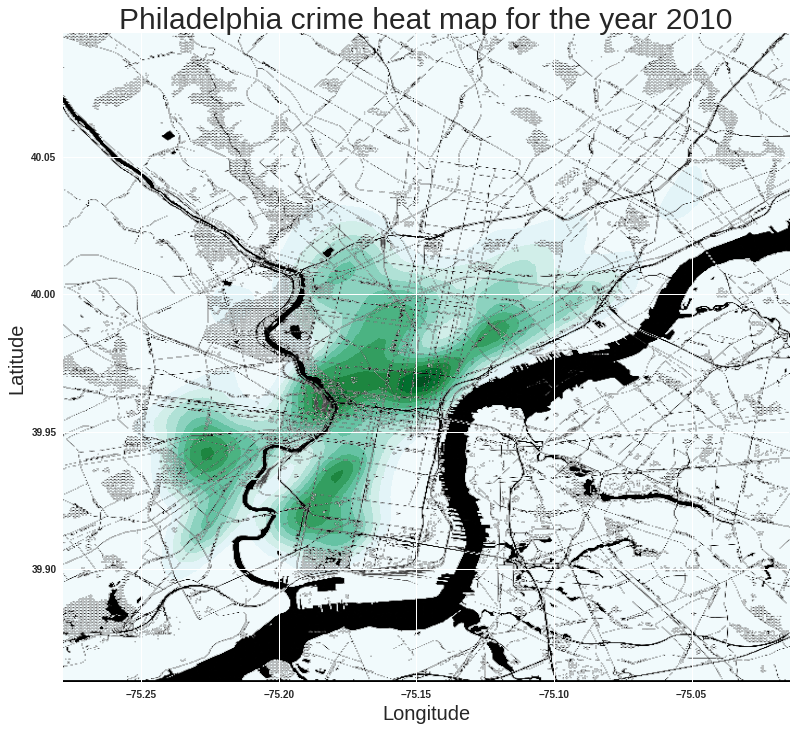

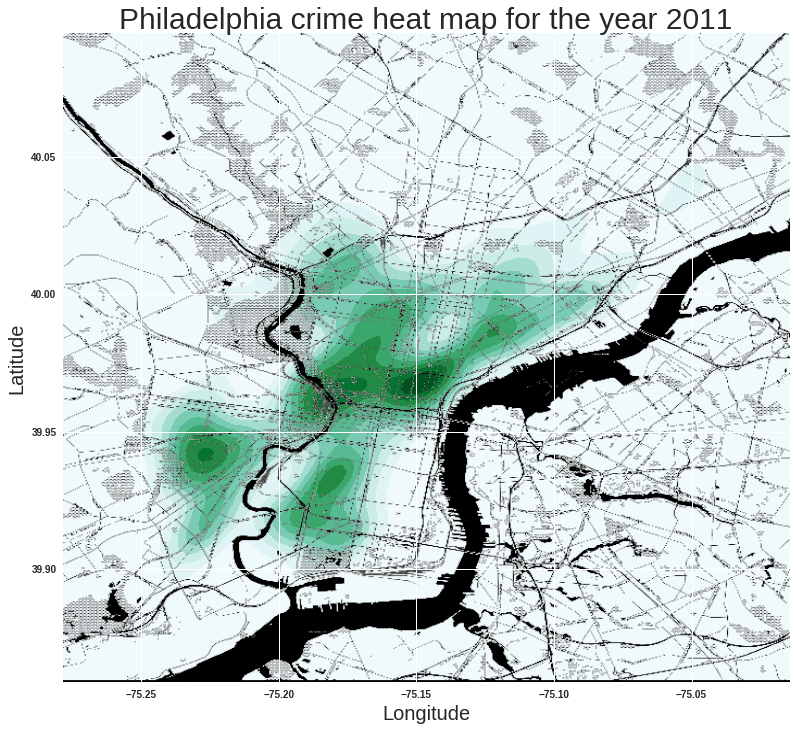

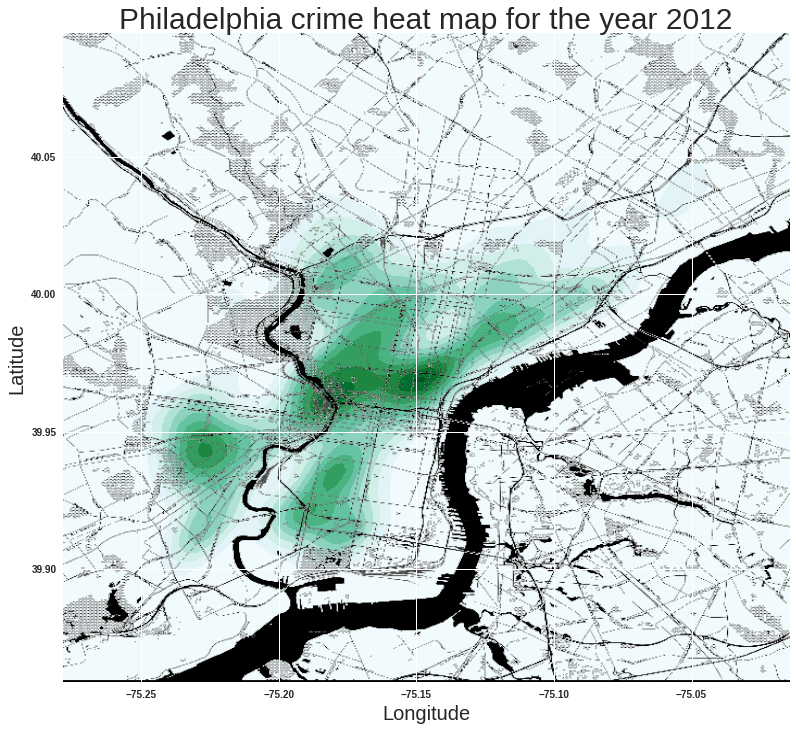

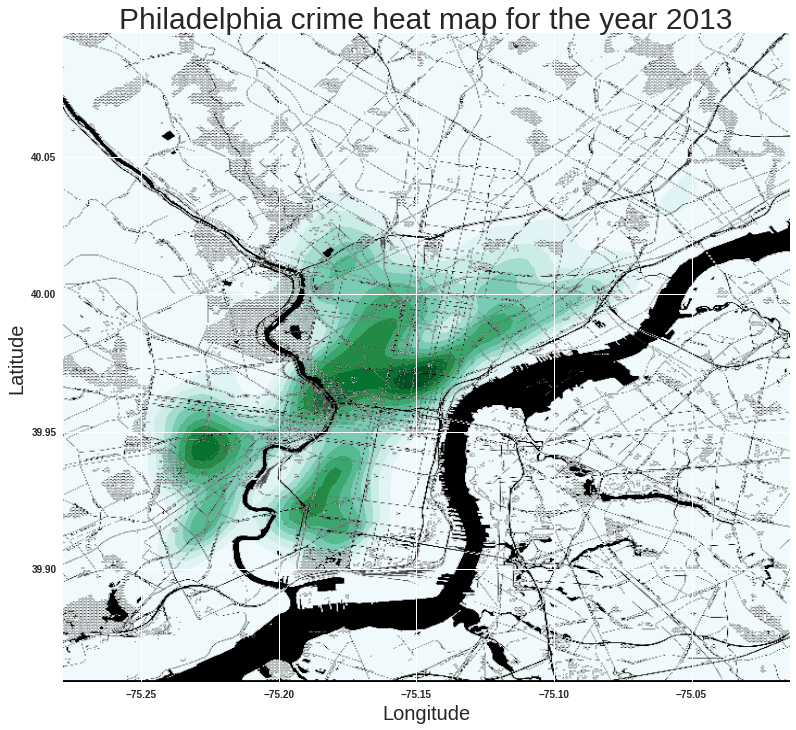

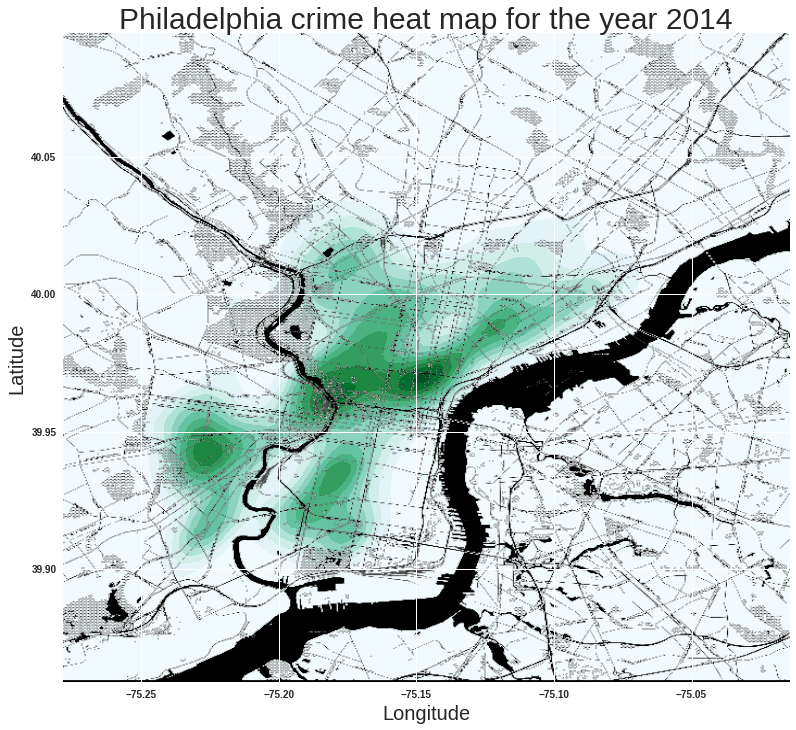

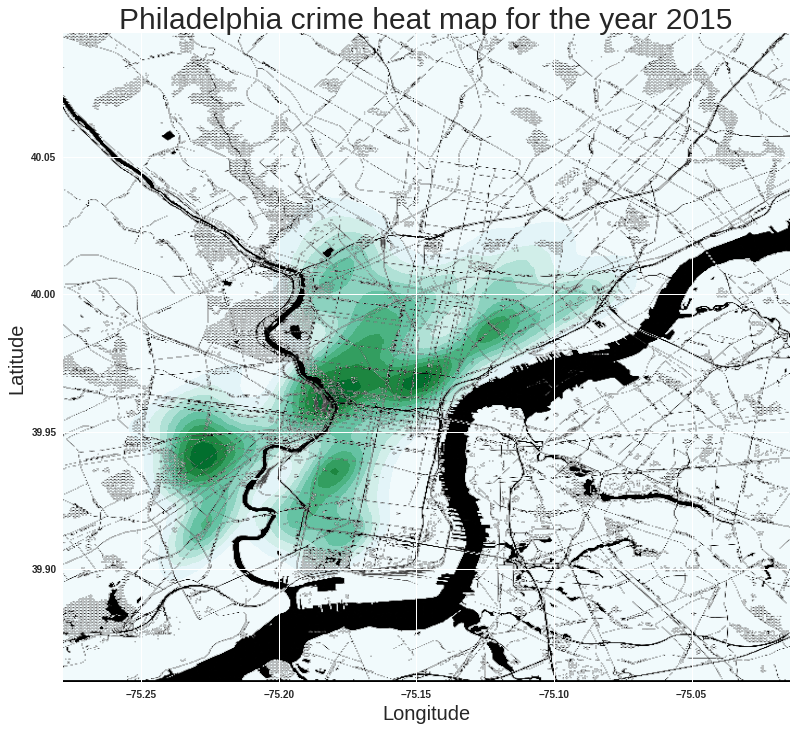

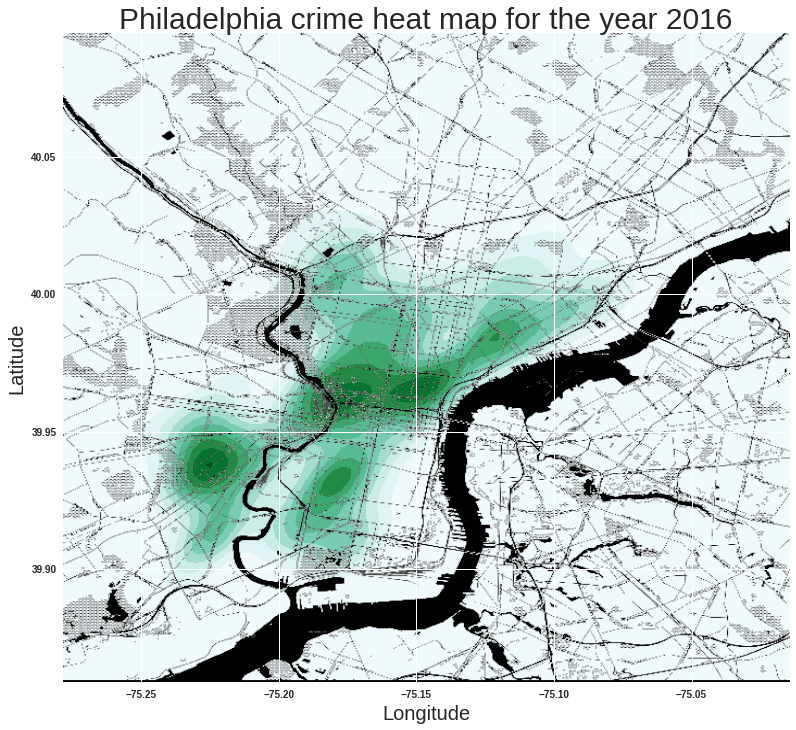

In [66]:
%matplotlib inline  

for year in np.arange(2006,2017):
    
    # Get the crime data for a particular year
    
    crime_given_year = crime_loc_df[crime_loc_df.Year==year]
    
    # Get a kernel density plot of the corresponding year's data using seaborn
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    plt.axis("off")
    sns.kdeplot(crime_given_year.lon.values, crime_given_year.lat.values, shade=True) 
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted()) #gets extent of bbox for just the plot (without the frame/padding), so we can save just the plot extent (no frame / axis), allowing us to overlay the images later
    plotname = 'philly_contour'+str(year)+'.png'
    plt.savefig(plotname, bbox_inches=extent) #save image of plot
    plt.close()
    
    # Overlay the kernel density plot with the map. This portion was done by Heather Simpson
    
    map_img = Image.open('philly_map.png')
    map_img = map_img.convert("RGBA")
    datas = map_img.getdata()

    newData = []
    for item in datas:
        if item[0] >200 and item[1] >200 and item[2] > 200:
            newData.append((item[0], item[1], item[2], 0))
        else:
            newData.append(item)
    map_img.putdata(newData)

    contourname = 'philly_contour'+str(year)+'.png'
    contour_img = Image.open(contourname)

    fig = plt.figure(figsize=(13,13))
    ax = plt.subplot(111)
    extent = xmin, xmax, ymin, ymax #note xmin, xmax, ymin, ymax come from tile map at beginning of script
    contourlayer = plt.imshow(contour_img,interpolation="nearest",extent=extent)
    plt.hold(True)
    map_layer = plt.imshow(map_img, alpha=1, interpolation='bilinear',extent=extent)
    plt.xlabel('Longitude',fontsize=20)
    plt.ylabel('Latitude',fontsize=20)
    plt.title('Philadelphia crime heat map for the year ' + str(year),fontsize=30)
    plt.show()
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted()) 
    plotname = 'philly_overlay.png' 
    plt.savefig(plotname, bbox_inches=extent)
    plt.close()


# We can see 3 major hotspots for crime. From my past research on crime in Philly, I am aware that North Philly is quite dangerous. The Temple University area is known to be rather dangerous and it turns out that it is a major crime hotspot every year (Broad St and Girard Avenue)

# West Philly, where we got robbed, is also a major crime hotspot. The data shows that the highest density of crime is near 50th-52nd and Market St, which has been labeled the "Worst Corner In The City" by the News Media and Philadelphia Police Department.

# Southwest Philly (just north of the airport) also appears to have significant levels of crime

# The safest parts of the city are center city (which is where most businesses are, and also where most young professionals live), and Southeast Philly. Southeast Philly is home to many tourist attractions like South St, and is also where many UPenn faculty reside

# Heather Simpson has done a lot of work on making more beautiful visualizations of the data. The link to her code is  [here](https://github.com/hsimpson22/PhillyCrimeMap/). Meanwhile, I would like to set up some statistical tests to answer some important questions

# First, I would like to test the hypothesis that there are more crimes in the spring and summer (when it's warmer) than in the fall and winter i.e.

## Null Hypothesis H0: There is no significant difference between the proportion of crimes that take place in spring and summer as compared to in the fall and winter
## Alternative Hypothesis H1: There are more crimes in the spring and summer than in the fall and winter

## I first do this with aggravated crime

In [214]:
crime_df = df[(df.CrimeCodeNo<500) | (df.CrimeCodeNo==800)].drop(['lat','lon','CrimeCodeNo','CrimeCodeText'],axis=1)

crime_df = crime_df.reset_index().drop('index',axis=1)

# We use the function PropHypTestSeason (defined below) to test if my hypothesis is true

PropHypTestSeason(crime_df)

Total number of crimes committed between Jan 2006 and Dec 2015 is 431860
Proportion of crimes committed in the Spring and Summer is 52.58 %
Proportion of crimes committed in the Fall and Winter is 47.42 %
Null Hypothesis H0: There is no difference between the number of crimes in SprSum and FaWin i.e. proportion of crimes committed = 50% for both
Alternative Hypothesis H1: There are more crimes committed in SprSum than in FaWin
p-value = 1.62516825502e-252


# As it turns out, when using a proportion hypothesis test z-test (since our sample size is large), the p-value is extremely small. This means that the probability of observing our sample when assuming that our null hypothesis is true is extremely small. Therefore, we can reject the null hypothesis in favor of the alternative hypothesis, with a very small chance of getting a Type 1 error

# Could it actually be that criminals stay indoors in the winter due to the cold? Let's test this using a 2-sample t-test

## Null Hypothesis H0: There is no significant difference between the proportion of crimes that take place in the winter as compared to the rest of the year
## Alternative Hypothesis H1: There are fewer crimes in the winter than during the rest of the year

Null Hypothesis H0: There is no difference between the number of crimes per day in winter and the rest of the year
Alternative Hypothesis H1: There are fewer crimes committed in winter than during the rest of the year
p-value = 8.15121149179e-100


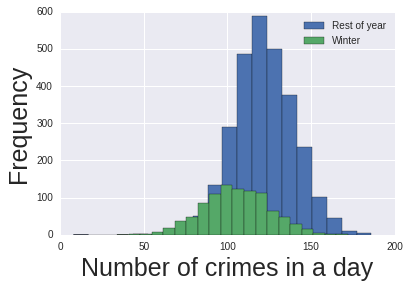

In [220]:
twoSampleTSeason(crime_df)

# The p-value shows that the difference in the sample means is significant. The probability of observing this difference in sample means assuming that the null hypothesis is true (the p-value) is extremely small. Therefore, we can reject the null hypothesis in favor of the alternative hypothesis with a high degree of confidence

In [211]:
def PropHypTestSeason(crime_df):
    
    # First, I remove the 2016 data to ensure that the data is not skewed i.e. four data comes from a set with
    # equal number of falls, winters, springs and summers
    
    crime_df = crime_df[[int(x[0:4])<2016 for x in crime_df.Date.values]].reset_index()
    
    # I then define SprSum to be March-August and FaWin to be September-February
    
    crime_df['Season'] = ['SprSum' if 3<=int(date[5:7])<=8 else 'FaWin' for date in crime_df.Date.values]
    
    # I then compute the proportion of crimes committed in each season
    
    grouped = crime_df.groupby('Season')
    prop =grouped.Date.count()/(len(crime_df))
    
    spsump = prop.SprSum*100
    fawinp = prop.FaWin*100
    num_samples = len(crime_df)

    print "Total number of crimes committed between Jan 2006 and Dec 2015 is " + str(num_samples)
    print "Proportion of crimes committed in the Spring and Summer is %.2f %%" %spsump
    print "Proportion of crimes committed in the Fall and Winter is %.2f %%" %fawinp
    
    #Is the crime significantly higher in the Spring and Summer than in the Fall and Winter?
    
    print "Null Hypothesis H0: There is no difference between the number of crimes in SprSum and FaWin i.e. proportion of crimes committed = 50% for both"
    print "Alternative Hypothesis H1: There are more crimes committed in SprSum than in FaWin"
    
    # Since the data follows a bernoulli distribution (1 for SprSum, 0 for Fa Win), we can easily compute
    # the sample standard deviation to be sqrt(prop.FaWin*prop.SprSum), which we can (biased-ly) assume
    # is equal to the population std. To get the std of the distribution of sample means, we divide this 
    # by sqrt(num_samples)
    
    dsm_std = np.sqrt(prop.FaWin*prop.SprSum/num_samples)
    
    # Assume our null hypothesis is true. Then we expect the mean of the bernoulli random variable to be .5
    # We can get the z-score to compute how many standard deviations away our sample mean is from the population
    # mean (which is equal to the mean of the distribution of sample means)
    
    Z = abs(prop.SprSum-.5)/dsm_std
    
    # From the z-score, we can compute the p-value
    p = stats.norm.sf(Z)
    print "p-value = " + str(p)    

In [219]:
def twoSampleTSeason(crime_df):
    
    # First, I classify the data by Winter and Rest of the year
    
    crime_df['Season'] = ['Others' if 3<=int(date[5:7])<=11 else 'Winter' for date in crime_df.Date.values]

    # For both classes, I get a distribution of the number of crimes committed per day
                          
    grouped = crime_df.groupby(['Season','Date'])
    ct = grouped.Date.count()
    ot_plot = plt.hist(ct.Others.values,bins=20,label = 'Rest of year')
    w_plot = plt.hist(ct.Winter.values,bins=20,label = 'Winter')
    plt.xlabel('Number of crimes in a day',fontsize = 25)
    plt.ylabel('Frequency',fontsize = 25)
    plt.legend()
                        
    print "Null Hypothesis H0: There is no difference between the number of crimes per day in winter and the rest of the year"
    print "Alternative Hypothesis H1: There are fewer crimes committed in winter than during the rest of the year"   
   
    # We run a t-test to see if we can reject the null hypothesis based on our sample, if we assume it is true
                          
    tteststat = stats.ttest_ind(ct.Winter.values, ct.Others.values,equal_var=False)
    
    print "p-value = " + str(tteststat.pvalue/2) # Divide by 2 since we are interested in 1-tailed value

## I'm curious if the same can be said for thefts

Total number of crimes committed between Jan 2006 and Dec 2015 is 381371
Proportion of crimes committed in the Spring and Summer is 51.82 %
Proportion of crimes committed in the Fall and Winter is 48.18 %
Null Hypothesis H0: There is no difference between the number of crimes in SprSum and FaWin i.e. proportion of crimes committed = 50% for both
Alternative Hypothesis H1: There are more crimes committed in SprSum than in FaWin
p-value = 3.07083411364e-112
Null Hypothesis H0: There is no difference between the number of crimes per day in winter and the rest of the year
Alternative Hypothesis H1: There are fewer crimes committed in winter than during the rest of the year
p-value = 1.1198663608e-108


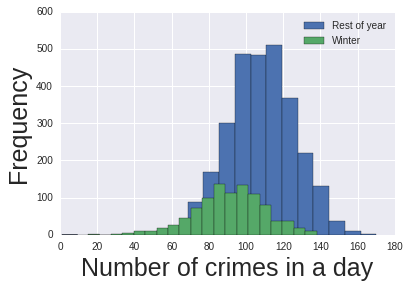

In [222]:
crime_df = df[(df.CrimeCodeNo==600)]
crime_df = crime_df.reset_index().drop('index',axis=1)
PropHypTestSeason(crime_df)
twoSampleTSeason(crime_df)

# And motor vehicle theft?

Total number of crimes committed between Jan 2006 and Dec 2015 is 43507
Proportion of crimes committed in the Spring and Summer is 50.32 %
Proportion of crimes committed in the Fall and Winter is 49.68 %
Null Hypothesis H0: There is no difference between the number of crimes in SprSum and FaWin i.e. proportion of crimes committed = 50% for both
Alternative Hypothesis H1: There are more crimes committed in SprSum than in FaWin
p-value = 0.0889560485495
Null Hypothesis H0: There is no difference between the number of crimes per day in winter and the rest of the year
Alternative Hypothesis H1: There are fewer crimes committed in winter than during the rest of the year
p-value = 0.0101096814656


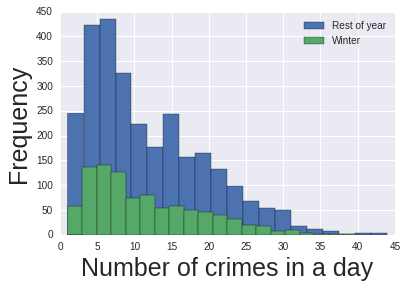

In [223]:
crime_df = df[(df.CrimeCodeText=="Motor Vehicle Theft")]
crime_df = crime_df.reset_index().drop('index',axis=1)
PropHypTestSeason(crime_df)
twoSampleTSeason(crime_df)

# There is only a 1% chance that the second null hypothesis is true given the data (i.e. there are probably fewer motor vehicle thefts in the winter). However, there is an 8% chance of a type 1 error if we conclude that there are more crimes in the fall and winter than in the spring and summer, so I cannot reject the first null hypothesis. 

# I need to be more careful when choosing the hypotheses, and not blindly apply the tests

# It is generally understood that more crime takes place during the night than during the day. I would like to see if the data supports this. For starters, let's (naively) run this on the entire dataset

## Null Hypothesis H0: There is no significant difference between the average number of crimes per night compared to the average number of crimes per day
## Alternative Hypothesis H1: There are on average fewer crimes per day than per night

Average number of crimes per day is 279.029929115
Average number of crimes per night is 269.717847769


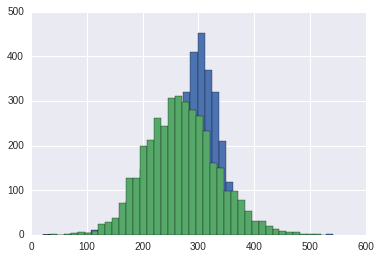

In [257]:
# (Naively) assume that night is 6pm - 6am and day is 6am to 6pm every day

df['TimeOfDay'] = ['Day' if 6<=int(time[0:2])<18 else 'Night' for time in df.Time.values]
grouped = df.groupby(['TimeOfDay','Date'])
ct = grouped.Date.count()
plt.hist(ct.Day.values,bins=40)
plt.hist(ct.Night.values,bins=40)
print "Average number of crimes per day is " + str(ct.Day.values.mean())
print "Average number of crimes per night is " + str(ct.Night.values.mean())

# On average, there seem to be fewer crimes per night than per day! Of course, this includes all sorts of crime, including recovery of stolen goods that can only happen during the day. Let's filter the aggravated crime again and see what happens

Average number of crimes per day is 57.9740089262
Average number of crimes per night is 59.66167979


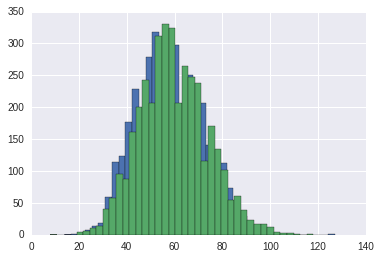

In [258]:
crime_df = df[(df.CrimeCodeNo<500) | (df.CrimeCodeNo==800)].drop(['lat','lon','CrimeCodeNo','CrimeCodeText'],axis=1)

crime_df = crime_df.reset_index().drop('index',axis=1)

# We use the function PropHypTestSeason (defined below) to test if my hypothesis is true

grouped = crime_df.groupby(['TimeOfDay','Date'])
ct = grouped.Date.count()
plt.hist(ct.Day.values,bins=40)
plt.hist(ct.Night.values,bins=40)
print "Average number of crimes per day is " + str(ct.Day.values.mean())
print "Average number of crimes per night is " + str(ct.Night.values.mean())

# They're actually pretty close, although there are marginally more during the night. Let's see if this is significant

In [263]:
tteststat = stats.ttest_ind(ct.Day.values, ct.Night.values,equal_var=False)
pvalue = tteststat.pvalue/2
pvalue

9.0749748025054415e-08

# Based on this, we can quite confidently reject the null hypothesis that there is an equal number of (aggravated) crime during the day as during the night. There are more of these crimes per night than per day. What about thefts?

Average number of crimes per day is 70.5085324232
Average number of crimes per night is 33.3183727034


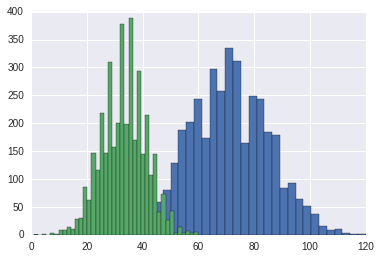

In [264]:
crime_df = df[(df.CrimeCodeNo==600)].drop(['lat','lon','CrimeCodeNo','CrimeCodeText'],axis=1)

crime_df = crime_df.reset_index().drop('index',axis=1)

# We use the function PropHypTestSeason (defined below) to test if my hypothesis is true

grouped = crime_df.groupby(['TimeOfDay','Date'])
ct = grouped.Date.count()
plt.hist(ct.Day.values,bins=40)
plt.hist(ct.Night.values,bins=40)
print "Average number of crimes per day is " + str(ct.Day.values.mean())
print "Average number of crimes per night is " + str(ct.Night.values.mean())

# This is interesting! I don't even have to run a t-test for this! My guess would be that theft that takes place in the night will only be reported missing during the day and therefore there are significantly more during the day

# Future work:

## 1) Study if most crime happens in the north philly hotspot
## 2) Study the other types of crime and find features that classify them uniquely (similar to what we did with night and day, seasons but different features)

In [10]:
test = df.dropna().reset_index()

In [11]:
test[['lat','lon']]

lat        lon
0        40.036389 -75.130477
1        39.969532 -75.166350
2        39.940070 -75.166412
3        39.979586 -75.171149
4        39.976134 -75.160229
5        39.977872 -75.163073
6        40.041270 -75.075602
7        39.990907 -75.122057
8        39.975724 -75.178874
9        40.012430 -75.069032
10       39.975197 -75.266605
11       39.959754 -75.235121
12       40.028490 -75.099584
13       39.959005 -75.217184
14       39.995626 -75.125869
15       40.040153 -75.176900
16       39.981381 -75.148657
17       39.965767 -75.246174
18       39.972396 -75.142238
19       39.965636 -75.231825
20       40.020219 -75.077126
21       39.968878 -75.236743
22       39.940641 -75.171071
23       39.994678 -75.094481
24       39.953878 -75.194694
25       40.006611 -75.213489
26       39.960435 -75.228597
27       39.949959 -75.223059
28       39.986415 -75.169577
29       40.046875 -75.070330
...            ...        ...
2090420  39.967796 -75.209712
2090421  39.992261 -75.174927
2090422  39.994880 -75.174348
2090423  39.993998 -75.172344
2090424  39.995073 -75.175888
2090425  39.971511 -75.159492
2090426  39.981364 -75.111698
2090427  40.021661 -75.112687
2090428  39.994718 -75.147506
2090429  40.003379 -75.106069
2090430  39.936284 -75.142777
2090431  39.927547 -75.162034
2090432  39.927567 -75.193260
2090433  40.037302 -75.073491
2090434  40.071264 -75.054188
2090435  39.953509 -75.163930
2090436  39.940671 -75.220013
2090437  39.913019 -75.244558
2090438  40.042931 -75.172203
2090439  39.951887 -75.159942
2090440  39.963169 -75.224953
2090441  40.044525 -75.179510
2090442  40.027797 -75.033272
2090443  40.031730 -75.030452
2090444  39.935782 -75.189698
2090445  39.948906 -75.239500
2090446  40.011360 -75.130461
2090447  39.978297 -75.124920
2090448  39.993671 -75.156388
2090449  40.037847 -75.130143

[2090450 rows x 2 columns]

In [ ]:
# zillow id X1-ZWz1fc8aeuonwr_7ew1d

In [113]:
crime_df = df[(df.CrimeCodeNo<500) | (df.CrimeCodeNo==800)].dropna().reset_index().drop(['index'],axis=1)
neilist = []
for i in xrange(10):#len(crime_df)
    url = 'http://api.phillyhoods.net/v1/locations/' + str(crime_df.iloc[i].lat) + ',' + str(crime_df.iloc[i].lon)
    try:
        resp = requests.get(url)
    except requests.exceptions.RequestException as e:    # This is the correct syntax
        print e
        sys.exit(1)
    jsondata = StringIO.StringIO(resp.content)
    data = json.load(jsondata)
    neilist.append(str(data['results']['features'][0]['properties']['name']))

In [114]:
len(neilist)

10